# Plotting

We introduce built-in plotting functions. 

A typical simulation requires visualizing:

1. geometry
2. simulation results in time or frequency domain
3. space-dependent arrays (such as eigenstates, charges, ...)

All public plotting functions are associated with a list of orbitals.

## Geometry

Geometries can be visualized in 2D or 3D.

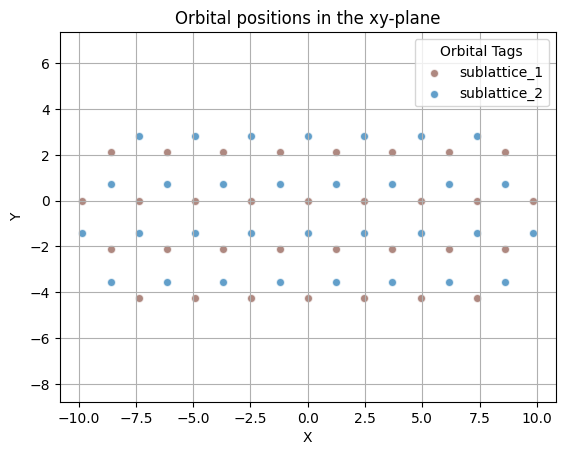

In [1]:
from granad import MaterialCatalog, Rectangle

flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake.show_2d()

If we have a stack

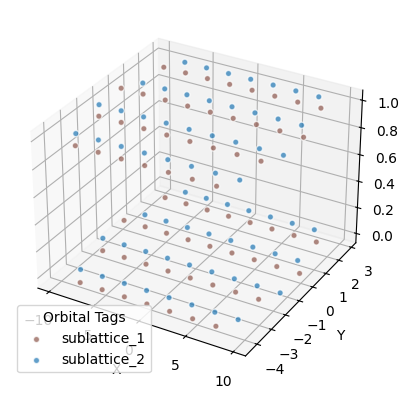

In [2]:
flake_shifted = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake_shifted.shift_by_vector( [0,0,1] )
stack = flake + flake_shifted
stack.show_3d()

## Simulation output

There is a dedicated function for showing time-domain simulation results. Let's illustrate this by tracking the current density considering the previously defined flake under x-polarized Gaussian pulsed illumination. The current density is related to the velocity operator given by the commutator of the system hamiltonian $H$ and the polarization operator $\bf{P}$

$$\bf{v} = \frac{-i}{\hbar} [H, \bf{P}]$$

The time-dependent induced current density is given by the expectation value of the operator $\bf{j} = e\bf{v}$. In GRANAD's units, setting the elementary charge $e = 1$, the velocity operator is thus identical to the current density operator, with which we can immediately evalute the induced currents due to the external field.

RHS compiled
RHS compiled


100.0 %


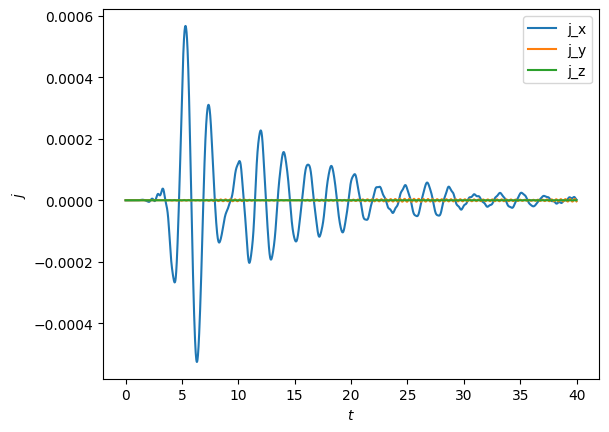

In [3]:
from granad import Pulse
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)
result = flake.master_equation(
    illumination=pulse,
    expectation_values = [flake.velocity_operator],
    end_time=40,
    relaxation_rate=1/10,
    grid=100, # save every 100-th time step
)
plot_labels = ['j_x', 'j_y', 'j_z'] 
flake.show_res( result, plot_labels = plot_labels, xlabel = r'$t$', ylabel = r'$j$')

A detailed description of parameters of the Gaussian pulse is given in the electric fields tutorial.

We can also Fourier transform the result to obtain the frequency domain result by specifying the omega limits. Note that omitting the variables xlabel and ylabel will result in no axis labels.

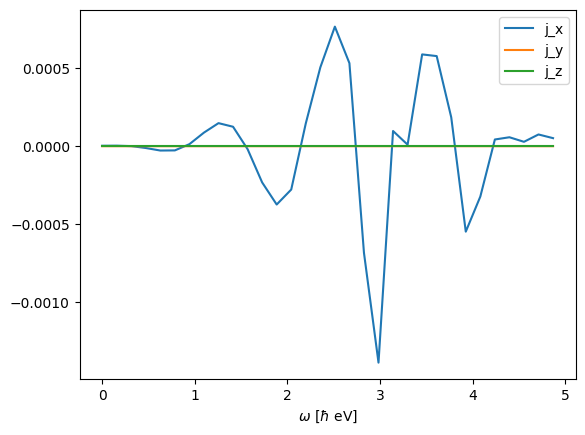

In [4]:
flake.show_res( result, omega_min = 0, omega_max = 5, plot_labels = plot_labels )

Note that the sparsity of the spectral grid ows to the sparse sampling in time domain which we have chosen for demonstrational purposes. A real simulation requires more careful refinement of the temporal grid. A finer temporal grid or longer integration time generally results in higher quality spectra.

## Space-dependent arrays

The functions show_2d and show_3d are a bit more versatile than initially indicated.

If we supply a "display" argument, we can plot an arbitrary array on the grid spanned by the orbitals and filter it by orbital tags. Let's demonstrate this by visualizing the lowest energy single-particle state of the flake

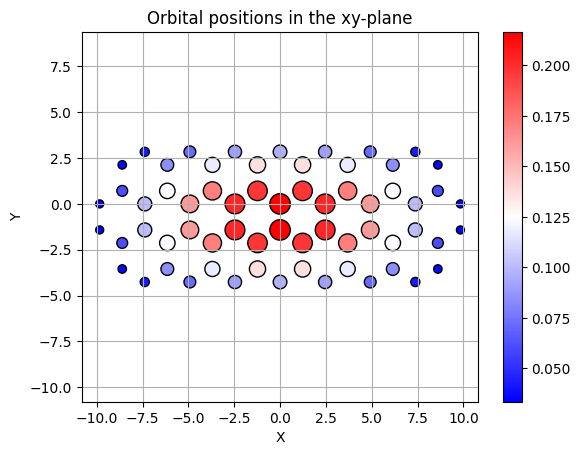

In [5]:
from granad import MaterialCatalog, Rectangle
flake.show_2d( display = flake.eigenvectors[:, 0] )

If you want a normalized plot of the absolute values, do

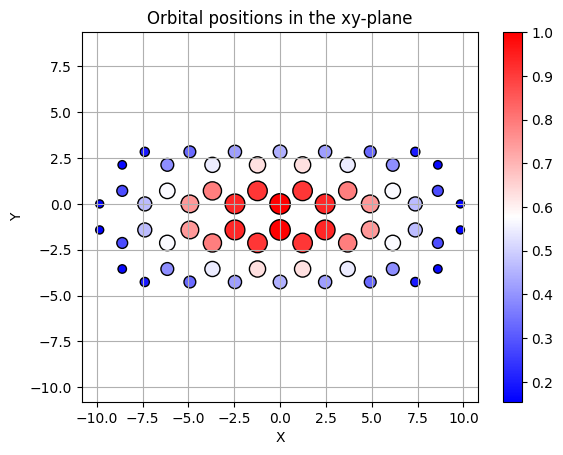

In [6]:
flake.show_2d( display = flake.eigenvectors[:, 0], scale = True )

By default, GRANAD automtically adjusts the colorbar range.
Furthermore, there are two special plot modes, given by the `mode` argument:

1. `mode = 'two-signed'`: This mode is designed for visualizing data with both positive and negative values, such as real parts of eigenvectors or signed distributions. The plot uses a diverging colormap (centered at zero) to clearly distinguish between positive and negative values.  The color limits are symmetrically set based on the maximum absolute value in the data, ensuring an even visual emphasis on both extremes. This mode is particularly useful for understanding symmetry or changes in sign within the data.

2. `mode = 'one-signed'`: This mode is intended for visualizing non-negative data or cases where only the magnitude of values is meaningful. A sequential colormap is used to highlight variations in the data, with darker shades typically representing larger values. Negative values in the `display` array are ignored in this mode, as the focus is on positive contributions. This mode works well for showing absolute values of data, such as the magnitude of eigenvectors or probabilities.

These modes provide flexibility in how data is visualized, depending on whether sign information is important or not.

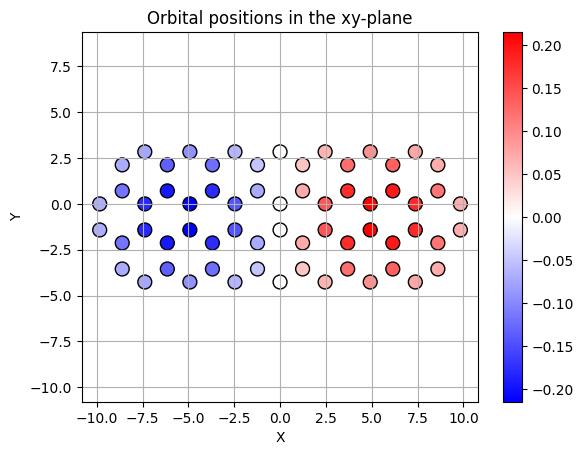

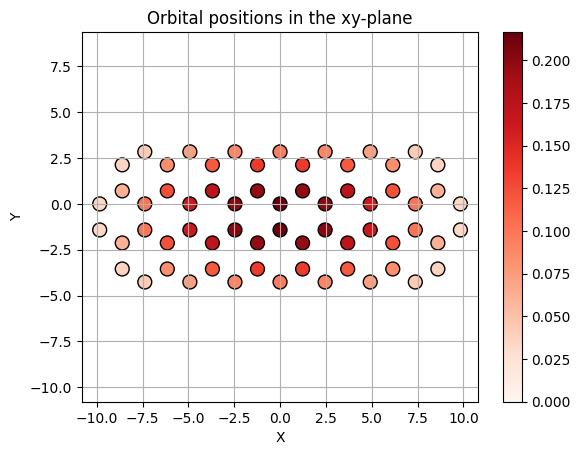

In [7]:
import jax.numpy as jnp
flake.show_2d( display = flake.eigenvectors[:, 1], mode = 'two-signed' )
flake.show_2d( display = jnp.abs(flake.eigenvectors[:, 0]), mode = 'one-signed' )

Additionally, if you supply the keyword argument name = "MY-PLOT-NAME.pdf" to any plotting function, the plot will not be displayed, but instead saved to disk in the directory you invoked Python.

# Induced field visualization

There exists a convenience function to compute and visualize the induced field at an arbitrary time step. 
To achieve this, we first run a full simulation of the system using the `flake.master_equation` function
and extract the density matrix at the last time step.

In [8]:
result = flake.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    end_time = 40,
    density_matrix = ["full"],
     )
density_matrix = result.output[-1]

RHS compiled
RHS compiled


100.0 %


Next, we define the extent of a 2D grid. This grid represents the spatial domain where the induced field 
will be evaluated. The grid points are created to encompass the range of particle positions in the x and y 
dimensions, extended slightly to include a buffer region.

In [9]:
import jax.numpy as jnp
xmin, xmax = flake.positions[:, 0].min(), flake.positions[:, 0].max()  # Compute the minimum and maximum x-coordinates 
                                                                       # of the particle positions.
x_grid = jnp.linspace(xmin - 1, xmax + 1, 40)  # Create a 1D array of 40 evenly spaced points in the x-direction, 
                                               # extending slightly beyond the range of the particles.

ymin, ymax = flake.positions[:, 1].min(), flake.positions[:, 1].max()  # Compute the minimum and maximum y-coordinates 
                                                                       # of the particle positions.
y_grid = jnp.linspace(ymin - 1, ymax + 1, 40)  # Create a 1D array of 40 evenly spaced points in the y-direction, 
                                               # extending slightly beyond the range of the particles.

Finally, we use the `show_induced_field` function to compute and visualize the induced field on the 
defined 2D grid. This function calculates the field based on the density matrix, evaluates it on the grid, 
and plots the normalized logarithmic magnitude of the induced field.

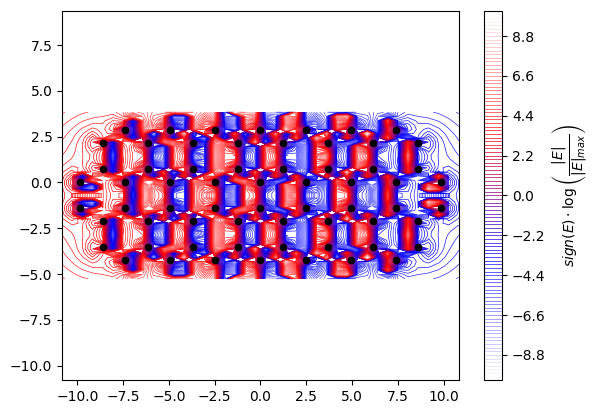

In [10]:
flake.show_induced_field(
    x = x_grid,              # The x-coordinates of the grid points where the field will be evaluated.
    y = y_grid,              # The y-coordinates of the grid points where the field will be evaluated.
    component = 0,           # Specifies which component (direction) of the field to visualize. 
                             # Here, the x-component (0) is selected.
    z = jnp.array([0]),      # The z-coordinate of the plane in which the field is evaluated. 
                             # Here, it is set to 0 to visualize the field in the xy-plane.
    density_matrix = density_matrix[-1]  # The final density matrix from the simulation is passed as an argument, 
                                         # ensuring that the field reflects the system's state at the final time step.
)